In [62]:
from pymarketng.application.Mechanism import *
from pymarketng.application.Utils import *
from pymarketng.application.BidsManager import BidsManager
from pymarketng.application.Plot import plot_demand_curves, plot_trades_as_graph
from pymarketng.application.Market import *

from pymarketng.domain.Bid import User
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from typing import Callable, List, Type


### Load Dataset

In [63]:
raw_df1 = pd.read_csv('datasets/21/final_df_type1.csv')
raw_df2 = pd.read_csv('datasets/21/final_df_type2.csv')
raw_df3 = pd.read_csv('datasets/21/final_df_type3.csv')
# raw_df.fillna(0, inplace=True)
raw_df1.dropna(inplace=True)
raw_df2.dropna(inplace=True)
raw_df3.dropna(inplace=True)

# TODO: drop is_seller nans
# raw_df

In [64]:
r = [raw_df1, raw_df2, raw_df3]
# Converting the shape of df to a simpler form (creating all_bids df)
new_list=[]
for raw_df in r:
    number_of_users = len([col for col in raw_df.columns if col.startswith('type')])
    first_user_num = int(''.join(filter(str.isdigit, raw_df.columns[1])))
    for i in range(first_user_num, first_user_num + number_of_users):
        bid = {
            "time":raw_df['time'],
            "is_peak":raw_df[f'is_peak_user{i}'],
            "load":raw_df[f'load_user{i}'],
            "generate":raw_df[f'generate_user{i}'] if f'generate_user{i}' in raw_df.columns else None,
            "SOC":raw_df[f'SOC_user{i}'] if f'SOC_user{i}' in raw_df.columns else None,
            'unit':raw_df[f'unit_user{i}'],
            "price":raw_df[f'price_user{i}'],
            "is_seller":raw_df[f'is_seller_user{i}'].astype(bool) if f'is_seller_user{i}' in raw_df.columns else False,
            "user": i,
            "type": raw_df[f'type_user{i}']
        }
        new_list.append(pd.DataFrame(bid))
df = pd.concat(new_list)

# drop bids with unit == 0 or price == 0
df = df[df['unit'] != 0]
df = df[df['price'] != 0]

# parsing the time
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour

# calculate price per unit
df['price'] = df['price'] / df['unit']

# compatability
df['is_buying'] = ~df['is_seller']

#
# df.loc[df['is_seller'] == True, 'unit'] *= 1.5
# df.loc[df['is_seller'] == True, 'unit'] += 200

# df.loc[df['is_seller'] == False, 'price'] *= 1.0
# df.loc[df['is_seller'] == False, 'unit'] += 200

df.reset_index(drop=True,inplace=True)
df

/tmp/ipykernel_150818/2350519929.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(new_list)


,time,is_peak,load,generate,SOC,unit,price,is_seller,user,type,hour,is_buying
0,2013-04-05 00:00:00,False,227.000000,NaN,NaN,227.000000,13.409051,False,151,1,0,True
1,2013-04-05 01:00:00,False,231.000000,NaN,NaN,231.000000,11.756055,False,151,1,1,True
2,2013-04-05 02:00:00,False,282.000000,NaN,NaN,282.000000,12.265838,False,151,1,2,True
3,2013-04-05 03:00:00,False,296.000000,NaN,NaN,296.000000,12.929247,False,151,1,3,True
4,2013-04-05 04:00:00,False,275.000000,NaN,NaN,275.000000,11.605919,False,151,1,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...
122905,2013-05-04 19:00:00,True,369.000000,143.488582,67.256777,27.109111,14.371405,True,99,3,19,False
122906,2013-05-04 20:00:00,True,1841.000000,0.000000,54.625751,748.484980,14.779662,False,99,3,20,True
122907,2013-05-04 21:00:00,True,551.000000,0.000000,0.000000,551.000000,14.884861,False,99,3,21,True
122908,2013-05-04 22:00:00,False,977.000000,0.000000,0.000000,977.000000,13.152193,False,99,3,22,True


In [65]:
# split sellers and buyers to different dataframes
buyers_df = df[df['is_seller'] == False]
sellers_df = df[df['is_seller'] == True]

In [66]:
time_list = df['time'].unique()
len(time_list)

720

### Max and Min Price

In [67]:
Min_price_seller = sellers_df['price'].min()
Max_price_seller = sellers_df['price'].max()
Min_price_buyer = buyers_df[buyers_df['price'] > 0]['price'].min()
Max_price_buyer = buyers_df['price'].max()
print('Max_price_buyer:',Max_price_buyer)
print('Min_price_buyer',Min_price_buyer)
print('Max_price_seller:',Max_price_seller)
print('Min_price_seller',Min_price_seller)
p_feat = 11.3
p_G = 16.68

Max_price_buyer: 16.080000000000002
Min_price_buyer 11.299999999999999
Max_price_seller: 16.680000000000017
Min_price_seller 11.299999999999997


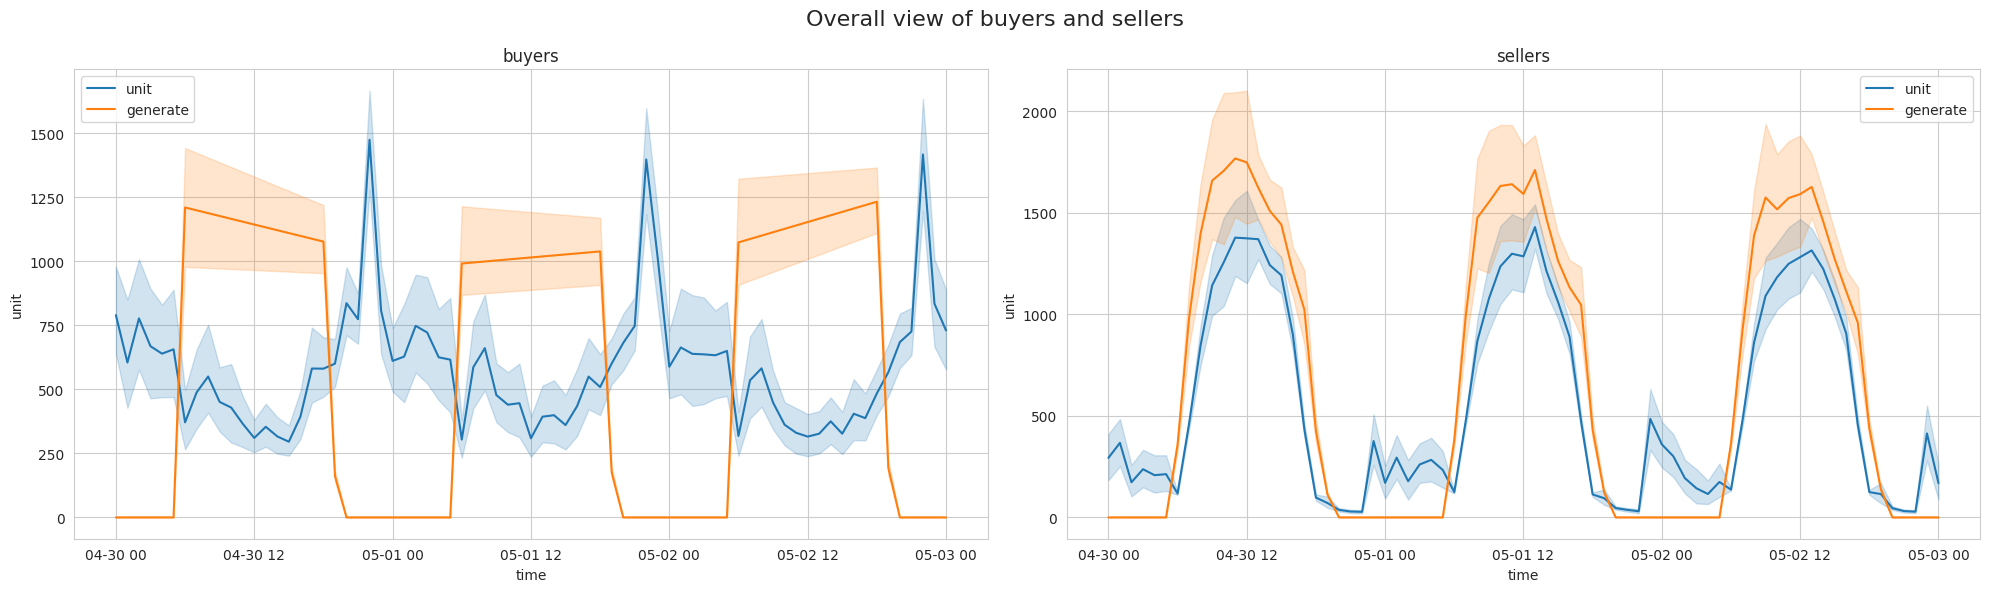

In [68]:
# TODO: move to lib
# TODO: needs update

# Define the start date and end date for the 7-day range
end_date = pd.to_datetime('2013-05-03')  # Example end date
start_date_week = end_date - pd.Timedelta(days=7)  # 7 days before the end date
start_date_3 = end_date - pd.Timedelta(days=3)  # 7 days before the end date

d_b = buyers_df.groupby('time').agg({'generate': 'mean', 'unit': 'mean', 'price': 'mean'}).reset_index()
d_s = sellers_df.groupby('time').agg({'generate': 'mean', 'unit': 'mean', 'price': 'mean'}).reset_index()

# Filter the DataFrame for the date range
buyers_df_week = buyers_df[(buyers_df['time'] >= start_date_week) & (buyers_df['time'] <= end_date)]
sellers_df_week = sellers_df[(sellers_df['time'] >= start_date_week) & (sellers_df['time'] <= end_date)]
buyers_df_3 = buyers_df[(buyers_df['time'] >= start_date_3) & (buyers_df['time'] <= end_date)]
sellers_df_3 = sellers_df[(sellers_df['time'] >= start_date_3) & (sellers_df['time'] <= end_date)]
df_3 = df[(df['time'] >= start_date_3) & (df['time'] <= end_date)]

# # Overall view of sellers and buyers
sns.set_style("whitegrid")
# # Create the plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
fig.suptitle('Overall view of buyers and sellers', fontsize=16)

# d_b = buyers_df.groupby('time').agg({'unit': 'mean', 'price': 'mean'}).reset_index()
# sns.lineplot(data=d, x='time', y='price', label='price', ax=axs[0])
sns.lineplot(data=buyers_df_3, x='time', y='unit', label='unit', ax=axs[0])
sns.lineplot(data=buyers_df_3, x='time', y='generate', label='generate', ax=axs[0])
axs[0].set_title('buyers')

axs[0].legend()

# d_s = sellers_df.groupby('time').agg({'unit': 'mean', 'price': 'mean'}).reset_index()
# sns.lineplot(data=d, x='time', y='price', label='price', ax=axs[1])
sns.lineplot(data=sellers_df_3, x='time', y='unit', label='unit', ax=axs[1])
sns.lineplot(data=sellers_df_3, x='time', y='generate', label='generate', ax=axs[1])
axs[1].set_title('sellers')
axs[1].legend()

plt.tight_layout()  # Adjust layout to make room for rotated labels

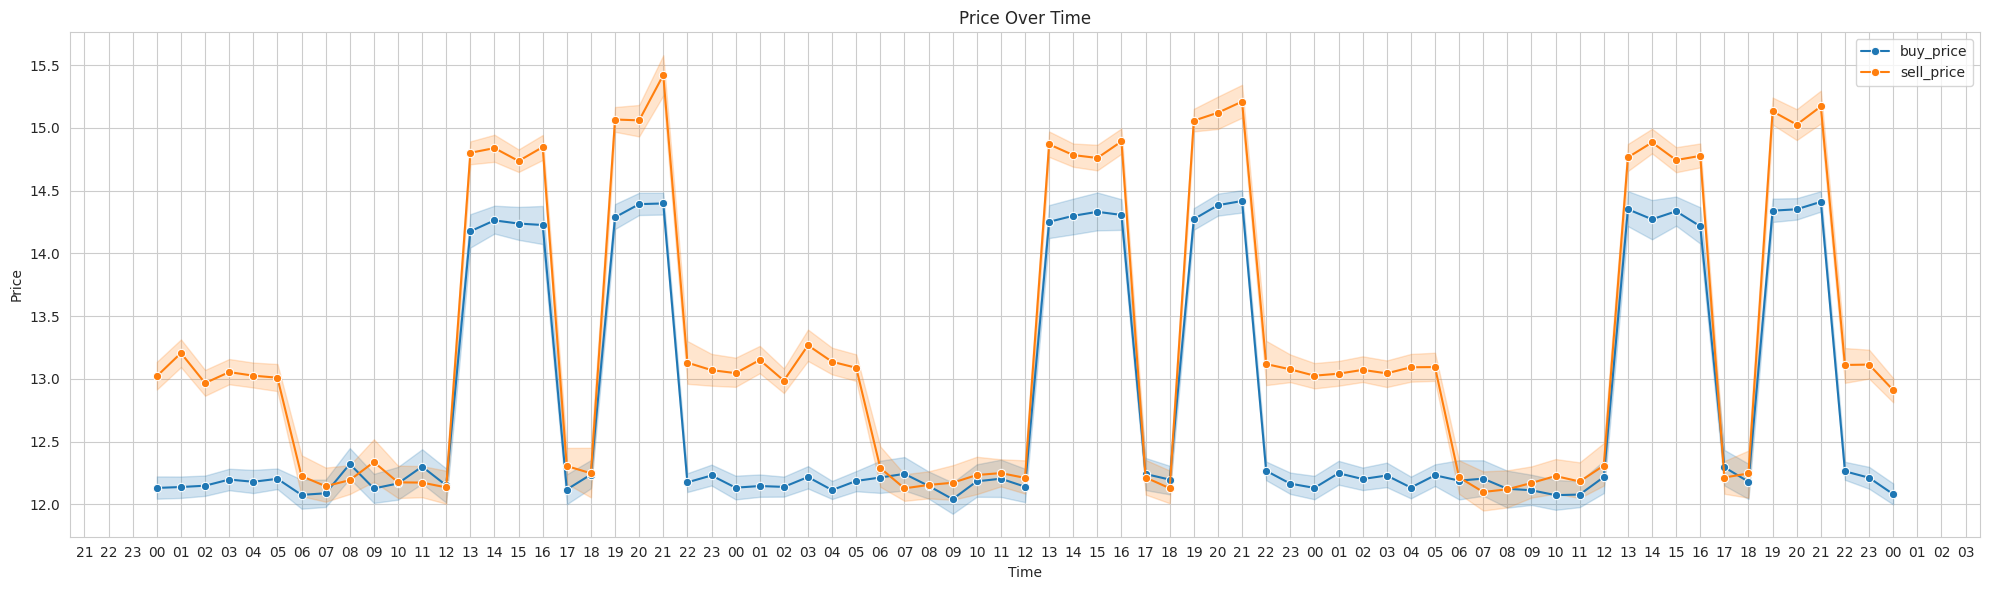

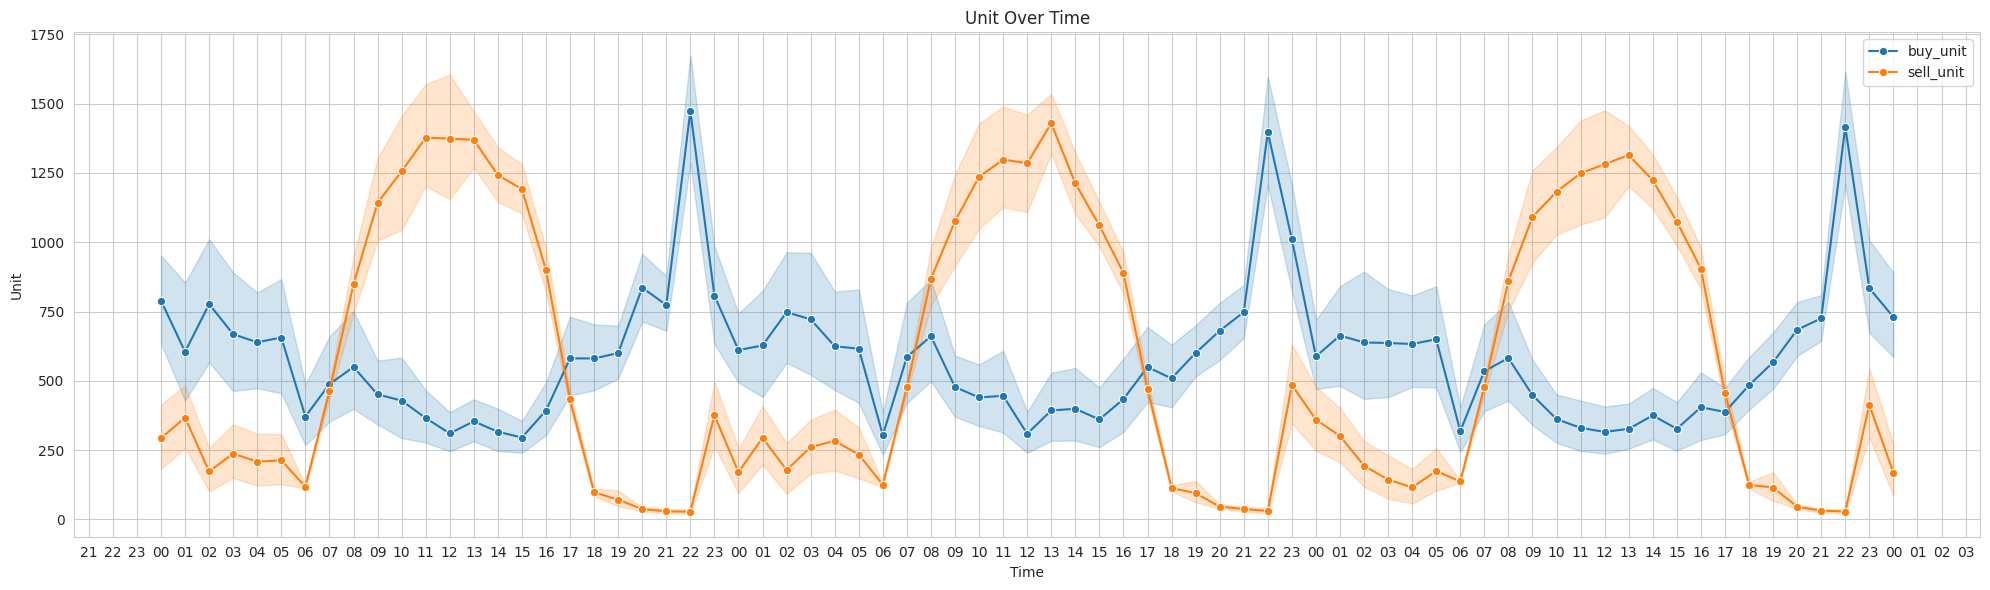

/tmp/ipykernel_150818/693452249.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyers_df_3['diff'] = sellers_df_3['unit'] - buyers_df_3['unit']


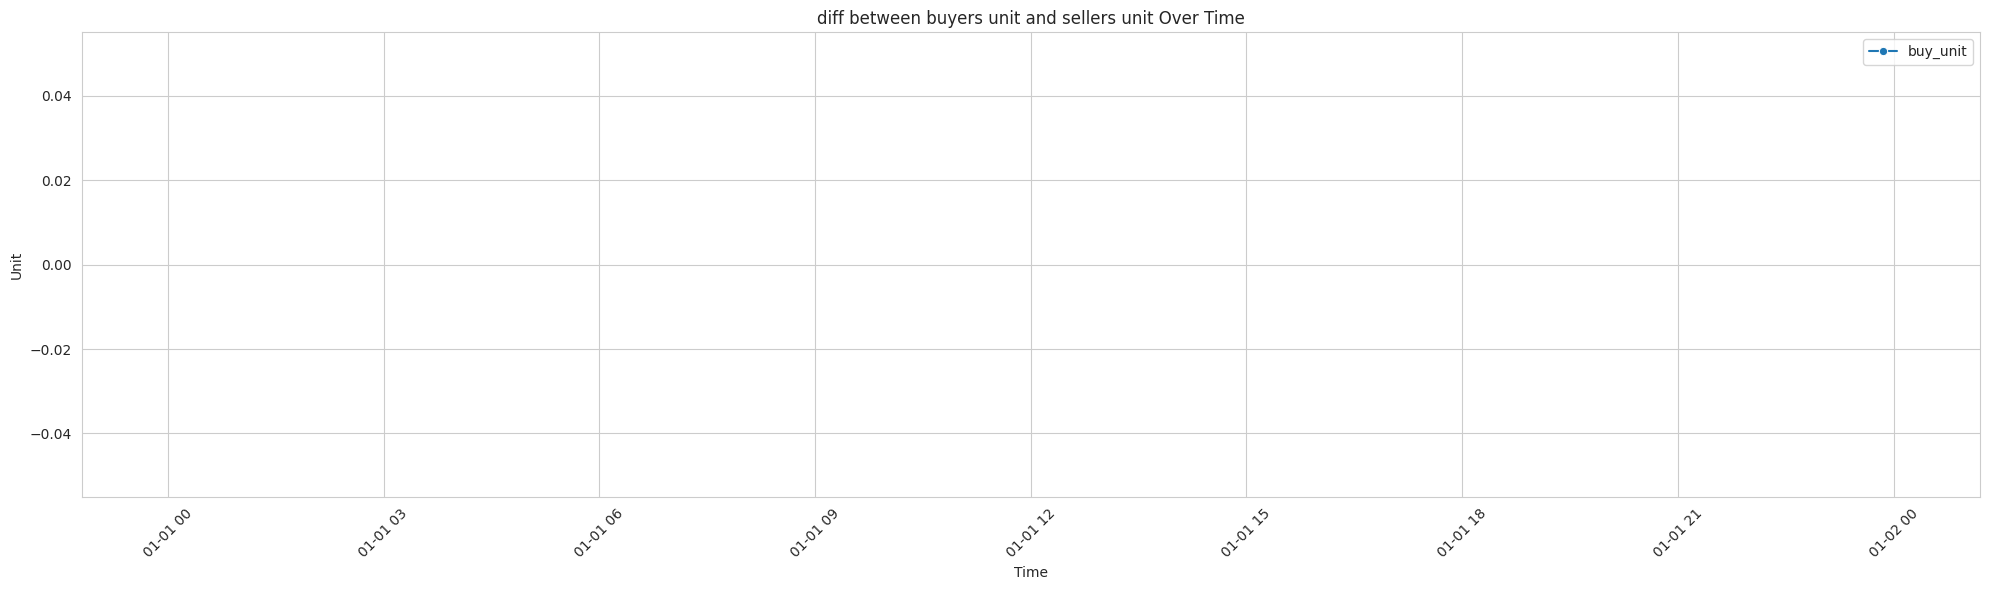

In [69]:
# TODO: move to library
import matplotlib.dates as mdates

sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=buyers_df_3, x='time', y='price', marker='o', label='buy_price')
sns.lineplot(data=sellers_df_3, x='time', y='price', marker='o', label='sell_price')
plt.title('Price Over Time')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlabel('Time')
plt.ylabel('Price')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=buyers_df_3, x='time', y='unit', marker='o', label='buy_unit')
sns.lineplot(data=sellers_df_3, x='time', y='unit', marker='o', label='sell_unit')
plt.title('Unit Over Time')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xlabel('Time')
plt.ylabel('Unit')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()


buyers_df_3['diff'] = sellers_df_3['unit'] - buyers_df_3['unit']
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=buyers_df_3, x='time', y='diff', marker='o', label='buy_unit')
plt.title('diff between buyers unit and sellers unit Over Time')
plt.xlabel('Time')
plt.ylabel('Unit')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()



In [70]:
merged = pd.merge(d_b, d_s, on='time', suffixes=('_b', '_s'))
merged[merged['price_b'] > merged['price_s']].reset_index(drop=True)

,time,generate_b,unit_b,price_b,generate_s,unit_s,price_s
0,2013-04-05 07:00:00,1460.664222,492.547104,12.227496,519.289248,179.196225,12.110869
1,2013-04-05 08:00:00,NaN,605.896552,12.249480,1156.908493,533.826860,12.201680
2,2013-04-05 10:00:00,NaN,557.403509,12.210928,1635.998920,1115.325451,12.169290
3,2013-04-05 12:00:00,NaN,450.285714,12.289873,1900.160883,1324.671087,12.084554
4,2013-04-05 17:00:00,1508.367884,619.943090,12.314888,580.159007,153.381229,12.290057
...,...,...,...,...,...,...,...
111,2013-05-03 06:00:00,1140.907934,313.280133,12.200566,383.400591,139.956146,12.160240
112,2013-05-03 12:00:00,NaN,407.581818,12.260735,1804.930444,1432.746771,12.182436
113,2013-05-03 17:00:00,NaN,487.175439,12.255775,971.898969,472.674479,12.222126
114,2013-05-03 18:00:00,1036.380751,517.000718,12.155270,490.598898,122.321120,12.106156


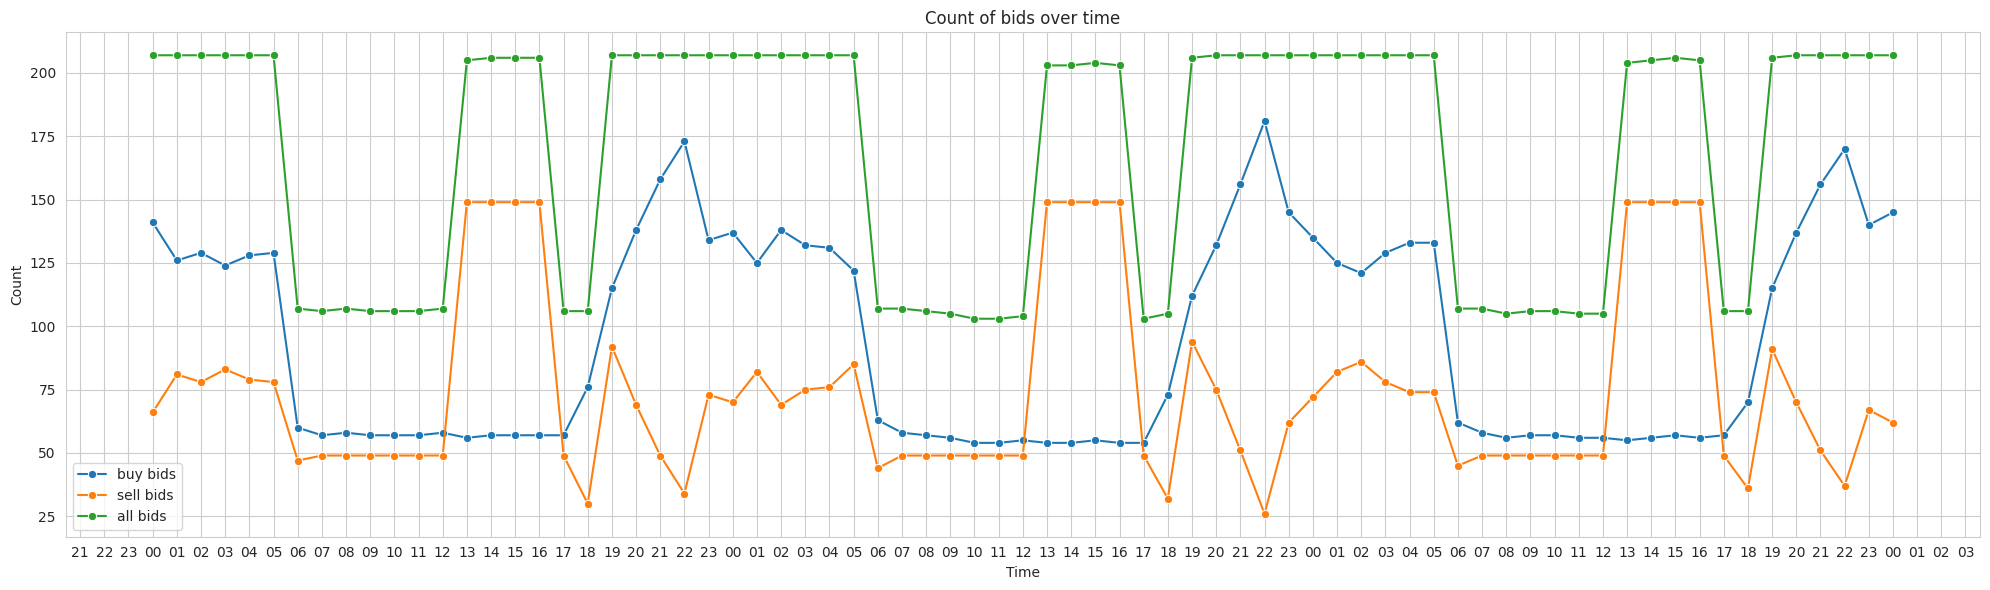

In [71]:
# TODO: move to library

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(20, 6))
buyers_bids_count = buyers_df_3.groupby('time').size().reset_index(name='count')
sellers_bids_count = sellers_df_3.groupby('time').size().reset_index(name='count')
all_bids_count = df_3.groupby('time').size().reset_index(name='count')
sns.lineplot(data=buyers_bids_count, x='time', y='count', marker='o', label='buy bids')
sns.lineplot(data=sellers_bids_count, x='time', y='count', marker='o', label='sell bids')
sns.lineplot(data=all_bids_count, x='time', y='count', marker='o', label='all bids')

# Add titles and labels
plt.title('Count of bids over time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels

# Show the plot
plt.show()

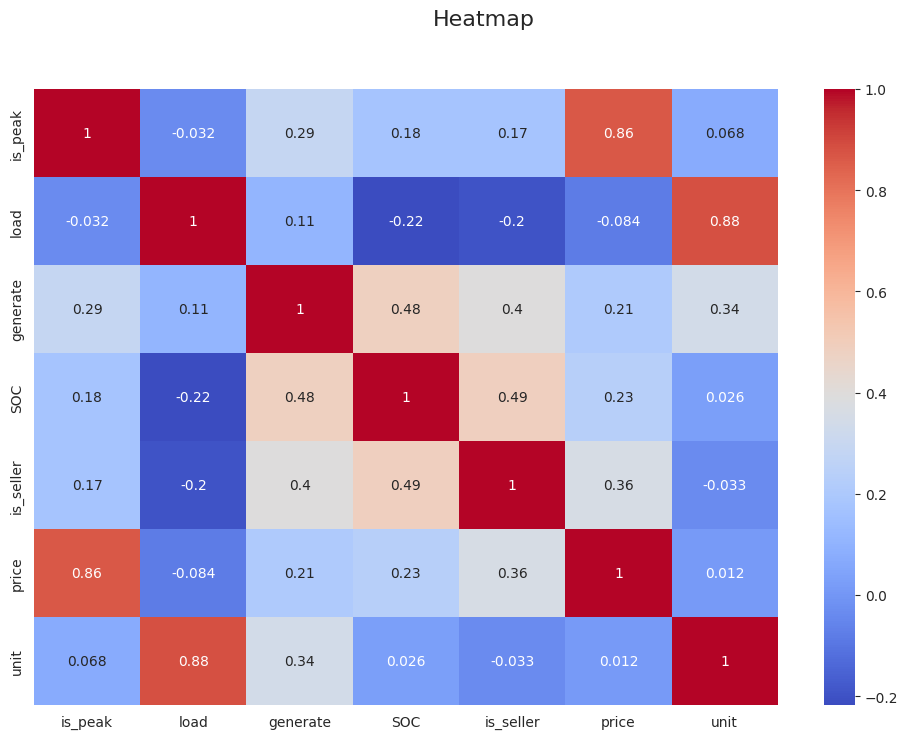

In [72]:
numerical_columns = ['is_peak', 'load', 'generate','SOC','is_seller', 'price', 'unit']
# numerical_columns = ['is_peak', 'is_seller', 'price', 'unit']
plt.figure(figsize=(12, 8))
plt.suptitle('Heatmap', fontsize=16)
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.show()

## Mechanism selection 

TODO: needs update

Our selection features:

1. number of participants (buyers/sellers/all) are low/high/neutral
2. buyers/sellers price or units are low/high/neutral
3. sellers units are higher/lower/equal to buyers
4. power of buyers and sellers regard together
3. we are in peak or not
4. number of outliers are low/high/neutral
5. anomaly detected based on the pattern of the each day plots (can detect outages caused by bad weathers)
6. profit of auctioneer
7. ...

In [73]:
import cProfile
from typing import Callable, Generator, List, Type

# TODO: needs more cleaning
def mechanism_selctor_idea1(
    bm_list: List[BidsManager], tm_list: List[TransactionManager], *args, **kwargs
) -> Generator[Type[Mechanism], None, None]:
    weight = 0
    thresh = 3
    auctioneer_profit_thresh = 1000
    policy = args[0]

    # storing data classified by hour TODO: use numpy series instead of python lists
    bms_by_hour = [[] for _ in range(24)]
    buyers_by_hour = [[] for _ in range(24)]
    sellers_by_hour = [[] for _ in range(24)]
    num_of_participants_by_hour = [[] for _ in range(24)]
    avg_unit_buyers_by_hour = [0 for _ in range(24)]
    avg_unit_sellers_by_hour = [0 for _ in range(24)]
    avg_prices_buyers_by_hour = [[] for _ in range(24)]
    avg_prices_sellers_by_hour = [[] for _ in range(24)]
    avg_price_buyers_by_hour = [0 for _ in range(24)]
    avg_price_sellers_by_hour = [0 for _ in range(24)]
    avg_prices_buyers = []
    avg_prices_sellers = []
    avg_d_prices_buyers = []
    avg_d_prices_sellers = []
    avg_d_price_buyers_by_hour = [0 for _ in range(24)]
    avg_d_price_sellers_by_hour = [0 for _ in range(24)]
    avg_score_participants = []
    num_of_transactions_by_hour = [[] for _ in range(24)]
    auctioneer_total_profit = 0
    while True:
        # things that should be updated for each round
        # general:
        current_round = bm_list[-1]
        current_round_index = len(bm_list)
        current_round_hour = current_round_index % 24
        bms_by_hour[current_round_hour].append(current_round)
        buyers_by_hour[current_round_hour].append(
            [b for i, b in current_round.buyers.iterrows()]
        )
        sellers_by_hour[current_round_hour].append(
            [s for i, s in current_round.sellers.iterrows()]
        )

        # num of participants:
        num_of_participants_by_hour[current_round_hour].append(
            current_round.get_number_of_participants()
        )

        # unit:
        avg_unit_current_round_buyers = calc_mean(
            [b.unit for i, b in current_round.buyers.iterrows()]
        )
        avg_unit_current_round_sellers = calc_mean(
            [b.unit for i, b in current_round.sellers.iterrows()]
        )
        avg_unit_buyers_by_hour[current_round_hour] = (
            avg_unit_buyers_by_hour[current_round_hour]
            * (len(bms_by_hour[current_round_hour]) - 1)
            + avg_unit_current_round_buyers
        ) / len(bms_by_hour[current_round_hour])
        avg_unit_sellers_by_hour[current_round_hour] = (
            avg_unit_sellers_by_hour[current_round_hour]
            * (len(bms_by_hour[current_round_hour]) - 1)
            + avg_unit_current_round_sellers
        ) / len(bms_by_hour[current_round_hour])
        
        # price:
        avg_price_current_round_buyers = calc_mean(
            [b.price for i, b in current_round.buyers.iterrows()]
        )
        avg_prices_buyers.append(avg_price_current_round_buyers)
        avg_prices_buyers_by_hour[current_round_hour].append(avg_price_current_round_buyers)

        avg_price_current_round_sellers = calc_mean(
            [b.price for i, b in current_round.sellers.iterrows()]
        )
        avg_prices_sellers.append(avg_price_current_round_sellers)
        avg_prices_sellers_by_hour[current_round_hour].append(avg_price_current_round_sellers)

        avg_price_buyers_by_hour[current_round_hour] = (
            avg_price_buyers_by_hour[current_round_hour]
            * (len(bms_by_hour[current_round_hour]) - 1)
            + avg_price_current_round_buyers
        ) / len(bms_by_hour[current_round_hour])

        avg_price_sellers_by_hour[current_round_hour] = (
            avg_price_sellers_by_hour[current_round_hour]
            * (len(bms_by_hour[current_round_hour]) - 1)
            + avg_price_current_round_sellers
        ) / len(bms_by_hour[current_round_hour])

        # d price
        if len(avg_d_prices_buyers) > 0:
            d = avg_price_current_round_buyers - avg_d_prices_buyers[-1]
            avg_d_prices_buyers.append(d)
            avg_d_price_buyers_by_hour[current_round_hour] = (
                avg_d_price_buyers_by_hour[current_round_hour]
                * (len(bms_by_hour[current_round_hour]) - 2)
                + d
                ) / len(bms_by_hour[current_round_hour] - 1)

        if len(avg_d_prices_sellers) > 0:
            d = avg_price_current_round_sellers - avg_d_prices_sellers[-1]
            avg_d_prices_sellers.append(d)
            avg_d_price_sellers_by_hour[current_round_hour] = (
                avg_d_price_sellers_by_hour[current_round_hour]
                * (len(bms_by_hour[current_round_hour]) - 2)
                + d
                ) / len(bms_by_hour[current_round_hour] - 1)


        # global scores for each mechnism TODO: should be automated since number of mechanisms in the future are not known
        avg_mechanism_score = 0
        vcg_mechanism_score = 0
        mcafee_mechanism_score = 0
        trm_mechanism_score = 0

        # avg prticipants
        if policy == "social_welfare":
            weight = 2
        elif policy == "utility_and_price":
            weight = 3

        z_score = calc_zscore(
            num_of_participants_by_hour[current_round_hour][:-1],
            num_of_participants_by_hour[current_round_hour][-1],
        )

        if z_score != np.nan:
            if z_score > 0 and z_score > thresh:
                avg_mechanism_score += weight
            elif z_score < 0 and z_score < -thresh:
                vcg_mechanism_score += weight

        # avg units
        if policy == "social_welfare":
            weight = 3
        elif policy == "utility_and_price":
            weight = 2

        # TODO: needs rethinking
        if (
            avg_unit_sellers_by_hour[current_round_hour] > 0
            and avg_unit_current_round_sellers > 0
        ):
            if (
                avg_unit_buyers_by_hour[current_round_hour]
                / avg_unit_sellers_by_hour[current_round_hour]
            ) < (avg_unit_current_round_buyers / avg_unit_current_round_sellers):
                trm_mechanism_score += weight

        # avg price
        if policy == "social_welfare":
            weight = 2
        elif policy == "utility_and_price":
            weight = 3

        # TODO: needs rethinking
        z_score_buyers = calc_zscore(
            avg_prices_buyers[:-1],
            avg_prices_buyers[-1],
        )
        z_score_sellers = calc_zscore(
            avg_prices_sellers_by_hour[current_round_hour][:-1],
            avg_prices_sellers_by_hour[current_round_hour][-1],
        )

        if z_score_buyers != np.nan:
            if z_score_buyers > 0 and np.abs(z_score_buyers) > thresh:
                mcafee_mechanism_score += weight
        if z_score_sellers != np.nan:
            if z_score_sellers > 0 and np.abs(z_score_sellers) > thresh:
                mcafee_mechanism_score += weight

        if avg_price_current_round_buyers > avg_price_current_round_sellers:
            vcg_mechanism_score += weight
        
        # TODO: d price
        

        # users score
        if policy == "social_welfare":
            weight = 3
        elif policy == "utility_and_price":
            weight = 2

        current_round_avg_score_of_participants = 0
        current_round_buyers_prices = [b.price for i, b in current_round.buyers.iterrows()]
        for i, b in current_round.buyers.iterrows():
            user = User(b.user)
            distanceToMeanPrice = calc_zscore(current_round_buyers_prices, b.price)
            distanceToMeanPrice = np.log(np.abs(distanceToMeanPrice)) if distanceToMeanPrice != np.nan else 0
            if b.is_peak:
                user.score += distanceToMeanPrice - 2
            else:
                user.score += distanceToMeanPrice - 1
            if len(user.transactions) > 0:
                last_transaction = user.transactions[-1]
                if last_transaction.mechanism_name == 'Leftover_Clear':
                    user.score -= 1
                else:
                    user.score += 1
            current_round_avg_score_of_participants += user.score

        current_round_sellers_prices = [b.price for i, b in current_round.buyers.iterrows()]
        for i, s in current_round.sellers.iterrows():
            user = User(s.user)
            distanceToMeanPrice = calc_zscore(current_round_sellers_prices, b.price)
            distanceToMeanPrice = np.log(np.abs(distanceToMeanPrice)) if distanceToMeanPrice != np.nan else 0
            if s.is_peak:
                user.score += distanceToMeanPrice + 2
            else:
                user.score += distanceToMeanPrice + 1
            if len(user.transactions) > 0:
                last_transaction = user.transactions[-1]
                if last_transaction.mechanism_name == 'Leftover_Clear':
                    user.score -= 1
                else:
                    user.score += 1
            current_round_avg_score_of_participants += user.score

        if len(current_round.buyers) + len(current_round.sellers) > 0:
            current_round_avg_score_of_participants = current_round_avg_score_of_participants / (
                len(current_round.buyers) + len(current_round.sellers)
            )
        mean = calc_mean(avg_score_participants)
        avg_score_participants.append(current_round_avg_score_of_participants)
        if mean < current_round_avg_score_of_participants:
            vcg_mechanism_score += weight
        
        # peak/nonpeak
        if policy == "social_welfare":
            weight = 2
        elif policy == "utility_and_price":
            weight = 3
        is_peak = current_round.get_df()['is_peak'][0]
        if is_peak:
            trm_mechanism_score -= weight
            mcafee_mechanism_score -= weight

        # number of matched orders
        if policy == "social_welfare":
            weight = 2
        elif policy == "utility_and_price":
            weight = 2

        if len(tm_list) > 1:
            last_tm = tm_list[-2]
            last_round_num_of_transactions = len(last_tm.trans)
            num_of_transactions_by_hour[current_round_hour].append(last_round_num_of_transactions)
            z_score = calc_zscore(num_of_transactions_by_hour[current_round_hour][:-1], last_round_num_of_transactions)
            if z_score != np.nan:
                if z_score > 0 and z_score > thresh:
                    avg_mechanism_score += weight
                elif z_score < 0 and z_score < -thresh:
                    vcg_mechanism_score += weight

        # TODO: number outlier

        # auctioneer
        if len(tm_list) > 1:
            last_tm = tm_list[-2]
            auctioneer_total_profit += last_tm.get_auctioneer_profit()

        # select best mechanism regarding to it's score
        # just a simple max function needed and then yield the corresponding mechanism
        max_score = max(
            avg_mechanism_score,
            vcg_mechanism_score,
            trm_mechanism_score,
            mcafee_mechanism_score,
        )
        print(
            avg_mechanism_score,
            trm_mechanism_score,
            vcg_mechanism_score,
            mcafee_mechanism_score,
            end=" ",
        )
        if max_score == 0:
            yield Macafee_Mechanism_Multi
            print("no-one")
        elif max_score == avg_mechanism_score:
            yield Average_Mechanism_Multi
            print("average")
        elif (
            max_score == vcg_mechanism_score
            and current_round.run(VCG_Mechanism_Multi)[1].get_auctioneer_profit()
            + auctioneer_total_profit
            > auctioneer_profit_thresh
        ):
            yield VCG_Mechanism_Multi
            print("VCG")
        elif max_score == mcafee_mechanism_score:
            yield Macafee_Mechanism_Multi
            print("mcafee")
        elif max_score == trm_mechanism_score:
            yield TradeReduction_Mechanism_Multi
            print("TRM")
        else:
            yield Macafee_Mechanism_Multi
            print("default")
        yield Leftover_Clear

def mechanism_selctor_mc(
    bm_list: List[BidsManager], tm_list: List[TransactionManager], *args, **kwargs
) -> Generator[Type[Mechanism], None, None]:
    while True:
        # print(len(bm_list))
        yield Macafee_Mechanism_Multi
        yield Leftover_Clear

def mechanism_selctor_avg(
    bm_list: List[BidsManager], tm_list: List[TransactionManager], *args, **kwargs
) -> Generator[Type[Mechanism], None, None]:
    while True:
        # print(len(bm_list))
        yield Average_Mechanism_Multi
        yield Leftover_Clear

def mechanism_selctor_trm(
    bm_list: List[BidsManager], tm_list: List[TransactionManager], *args, **kwargs
) -> Generator[Type[Mechanism], None, None]:
    while True:
        # print(len(bm_list))
        yield TradeReduction_Mechanism_Multi
        yield Leftover_Clear

def mechanism_selctor_vcg(
    bm_list: List[BidsManager], tm_list: List[TransactionManager], *args, **kwargs
) -> Generator[Type[Mechanism], None, None]:
    while True:
        # print(len(bm_list))
        yield VCG_Mechanism_Multi
        yield Leftover_Clear


m = Market(mechanism_selctor_idea1, bid_selector_1h, df, "social_welfare")
# cProfile.run('m.run(p_feat, p_G)',filename="run.profile",sort=1)
m.run(p_feat, p_G)
print("------ bm stats:")
print(m.get_BMs_stats())

print("------ tm stats:")
print(m.get_TMs_stats())

0 0 2 0 default
0 0 0 0 no-one
0 0 0 0 no-one
0 0 0 0 no-one
0 0 0 0 no-one
0 0 0 2 mcafee
0 0 0 0 no-one
0 0 2 0 default
0 0 2 0 default
0 0 0 0 no-one
0 0 2 0 VCG
0 0 0 0 no-one
0 0 2 0 default
0 -2 3 0 VCG
0 -2 3 0 VCG
0 -2 3 -2 VCG
0 -2 3 -2 VCG
0 0 2 0 VCG
0 3 2 0 TRM
0 1 3 -2 VCG
0 1 3 -2 VCG
0 1 3 -2 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 TRM
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 TRM
0 0 3 0 VCG
0 0 3 0 VCG
0 0 0 0 no-one
0 0 0 0 no-one
0 0 2 0 default
2 0 0 0 average
0 0 0 0 no-one
2 0 2 0 average
0 -2 3 -2 VCG
0 -2 5 -2 VCG
2 -2 3 -2 VCG
0 -2 3 -2 VCG
2 0 2 0 average
0 3 0 0 TRM
0 1 3 -2 VCG
0 1 3 -2 VCG
0 1 3 -2 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 3 3 0 VCG
0 0 3 0 VCG
0 0 0 0 no-one
0 0 2 0 VCG
0 0 0 0 no-one
0 0 0 0 no-one
0 0 2 0 VCG
0 0 0 0 no-one
0 -2 3 -2 VCG
0 -2 3 -2 VCG
0 -2 3 -2 VCG
0 -2 3 -2 default
0 0 2 0 VCG
0 3 0 0 TRM
0 1 3 -2 VCG
0 1 3 -2 VCG
0 1 3 -2 VCG
0 3 3 0 VCG
0 3 3 0 TRM
0 3 3 0 VCG
0 3 3 0 VCG


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f899a9edca0>>
Traceback (most recent call last):
  File "/home/erfoo/books/papers/p2p-energy-trading/mine/codes/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


0 -2 3 -2 VCG
0 -2 3 -2 VCG
0 0 2 0 VCG
0 3 0 0 TRM
0 1 3 -2 VCG
0 1 3 -2 default
0 1 3 -2 VCG
0 3 3 0 VCG
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 0 0 0 no-one
0 0 0 0 no-one
0 0 2 0 VCG
0 0 2 0 VCG
0 0 0 0 no-one
0 0 2 0 VCG
0 0 2 0 default
0 -2 3 -2 VCG
0 -2 3 -2 VCG
0 -2 5 -2 VCG
0 -2 0 -2 no-one
0 0 2 0 VCG
0 3 2 0 TRM
0 1 0 -2 TRM
0 1 0 -2 TRM
0 1 0 -2 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
2 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 0 0 0 no-one
0 3 2 0 TRM
0 0 2 0 VCG
0 0 0 0 no-one
0 0 0 0 no-one
0 0 0 0 no-one
0 0 2 0 VCG
0 -2 0 -2 no-one
0 1 0 -2 TRM
2 -2 0 -2 average
0 1 0 -2 TRM
0 0 2 0 VCG
0 3 2 0 TRM
0 1 0 -2 TRM
0 1 0 -2 TRM
0 1 0 -2 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 3 0 0 TRM
0 0 0 0 no-one
0 0 0 0 no-one
0 0 0 0 no-one
0 0 2 0 VCG
0 0 0 0 no-one
0 0 0 0 no-one
0 0 2 0 VCG
0 0 2 0 VCG
0 -2 0 -2 no-one
0 -2 0 -2 no-one
0 -2 0 -2 no-one
0 -2 0 -2 no-one
0 0 0 0 no-

In [ ]:
tms = m.get_TMs_stats()
tms

,mechanism,players_total_trade_profit,players_total_trade_unit,auctioneer_profit,number_of_transactions,average_score_of_users,time
0,Macafee_Mechanism_Multi,0.000000e+00,0.000000,0.000000,0,0.000000,0
1,Leftover_Clear,1.113648e+07,333827.228656,0.000000,207,-863.646034,0
2,Macafee_Mechanism_Multi,2.391429e+05,9374.703386,0.000000,34,-741.832170,0
3,Leftover_Clear,4.193784e+06,143943.102288,0.000000,173,-873.681433,0
4,Macafee_Mechanism_Multi,1.159775e+05,4564.951817,47.627542,33,-1703.433806,0
...,...,...,...,...,...,...,...
1435,Leftover_Clear,3.394796e+06,102116.655545,0.000000,183,-994.665619,0
1436,VCG_Mechanism_Multi,1.852955e+04,709.028777,-34.287691,19,313.094918,0
1437,Leftover_Clear,7.442804e+06,223310.925256,0.000000,188,-971.205034,0
1438,VCG_Mechanism_Multi,2.229575e+05,8747.063042,-103.846134,41,-695.393248,0


In [ ]:
p2p_tms = tms[tms['mechanism'] != "Leftover_Clear"]
infra_tms = tms[tms['mechanism'] == "Leftover_Clear"]
p2p_tms.reset_index(inplace=True, drop=True)
infra_tms.reset_index(inplace=True, drop=True)
p2p_tms_filter = p2p_tms.iloc[450:550]
infra_tms_filter = infra_tms.iloc[450:550]
p2p_tms_filter

,mechanism,players_total_trade_profit,players_total_trade_unit,auctioneer_profit,number_of_transactions,average_score_of_users,time
450,TradeReduction_Mechanism_Multi,22344.648556,865.383939,0.393933,15,-3307.074720,0
451,VCG_Mechanism_Multi,38638.322815,1306.963729,-5.713582,28,-1333.213388,0
452,VCG_Mechanism_Multi,21980.491540,735.887823,-1.885529,26,-283.824639,0
453,VCG_Mechanism_Multi,21182.839676,701.891726,-16.136197,27,424.166866,0
454,VCG_Mechanism_Multi,7001.186520,269.177560,-7.097082,13,541.307429,0
...,...,...,...,...,...,...,...
545,Macafee_Mechanism_Multi,242023.029015,10060.308701,78.470821,44,-3446.879193,0
546,TradeReduction_Mechanism_Multi,32506.040467,1291.357040,427.899780,16,-3263.116528,0
547,VCG_Mechanism_Multi,58450.578768,1970.859826,-12.908994,28,-1129.629236,0
548,VCG_Mechanism_Multi,24293.585780,819.329774,-3.817326,27,-1578.007230,0


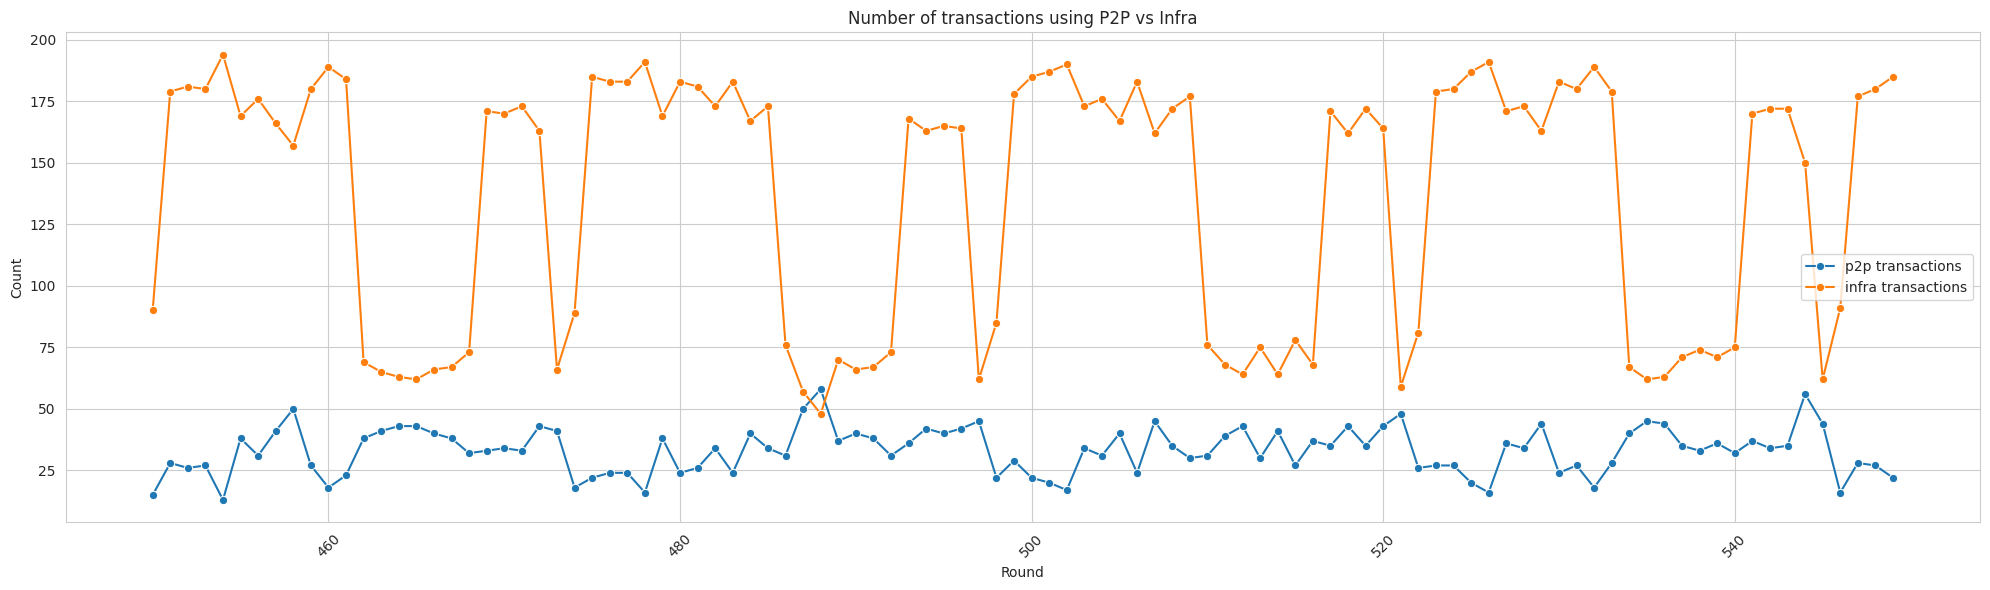

In [ ]:
# p2p
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=p2p_tms_filter, x=p2p_tms_filter.index, y='number_of_transactions', marker='o', label='p2p transactions')
sns.lineplot(data=infra_tms_filter, x=infra_tms_filter.index, y='number_of_transactions', marker='o', label='infra transactions')
plt.title('Number of transactions using P2P vs Infra')
plt.xlabel('Round')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

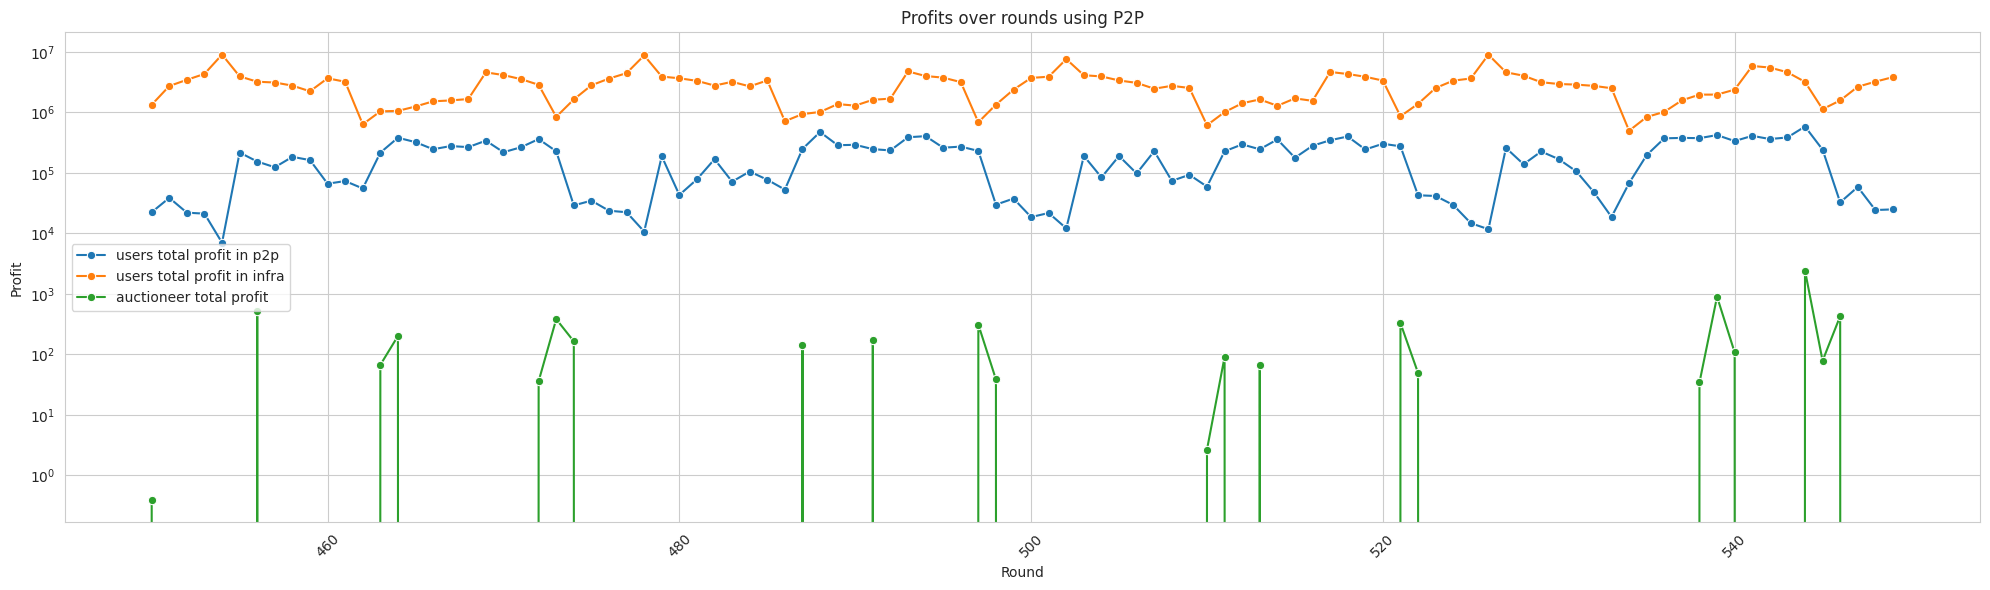

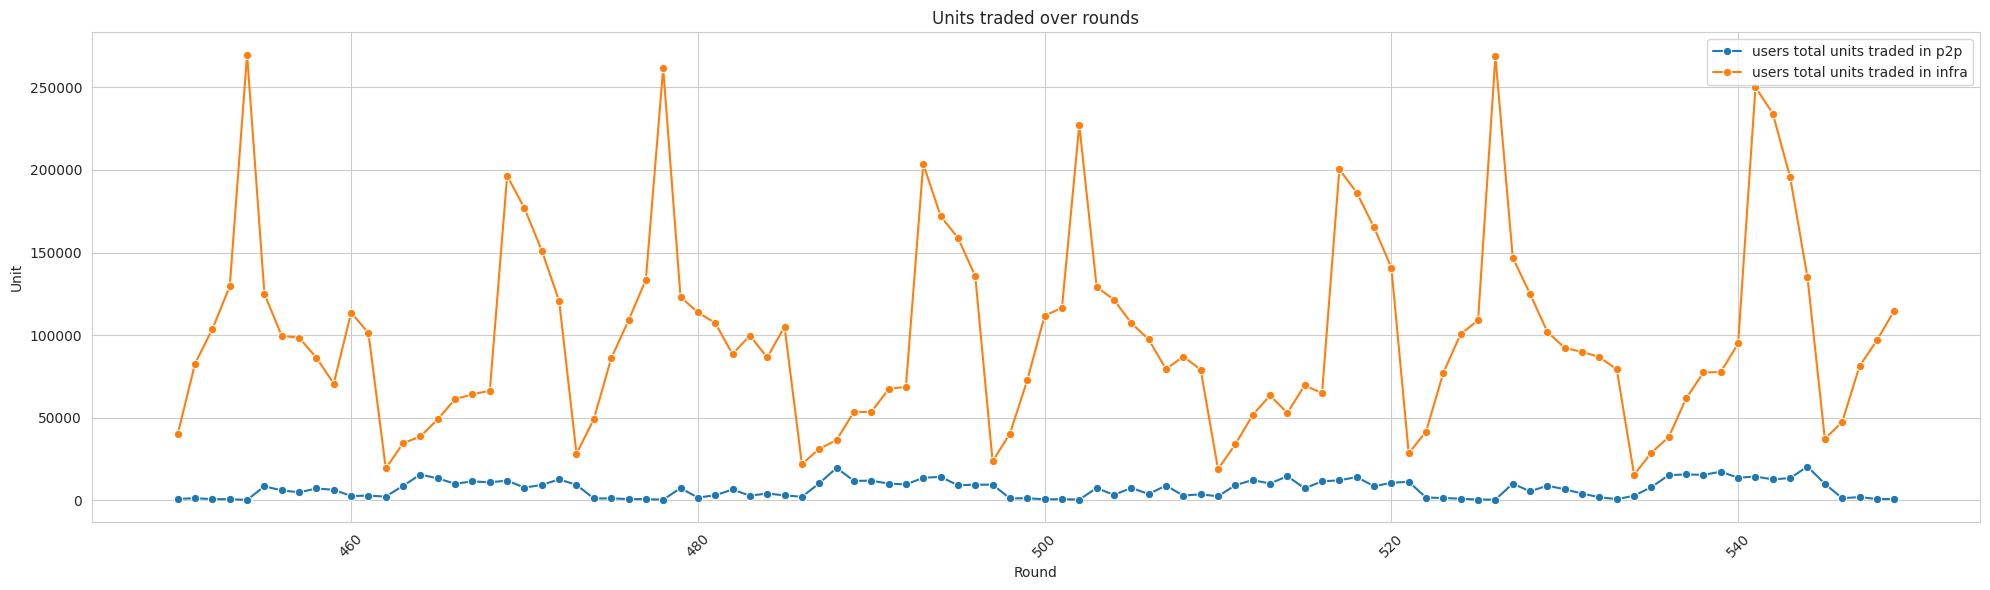

In [ ]:
# p2p
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=p2p_tms_filter, x=p2p_tms_filter.index, y='players_total_trade_profit', marker='o', label='users total profit in p2p')
sns.lineplot(data=infra_tms_filter, x=infra_tms_filter.index, y='players_total_trade_profit', marker='o', label='users total profit in infra')
sns.lineplot(data=p2p_tms_filter, x=p2p_tms_filter.index, y='auctioneer_profit', marker='o', label='auctioneer total profit')
plt.title('Profits over rounds using P2P')
plt.xlabel('Round')
plt.ylabel('Profit')
plt.yscale('log')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

# unit
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=p2p_tms_filter, x=p2p_tms_filter.index, y='players_total_trade_unit', marker='o', label='users total units traded in p2p')
sns.lineplot(data=infra_tms_filter, x=infra_tms_filter.index, y='players_total_trade_unit', marker='o', label='users total units traded in infra')
plt.title('Units traded over rounds')
plt.xlabel('Round')
plt.ylabel('Unit')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()


,categories,values
0,total profit users in p2p,5.877850
1,total profit users in infra,94.122098
2,total profit auctioneer,0.000051


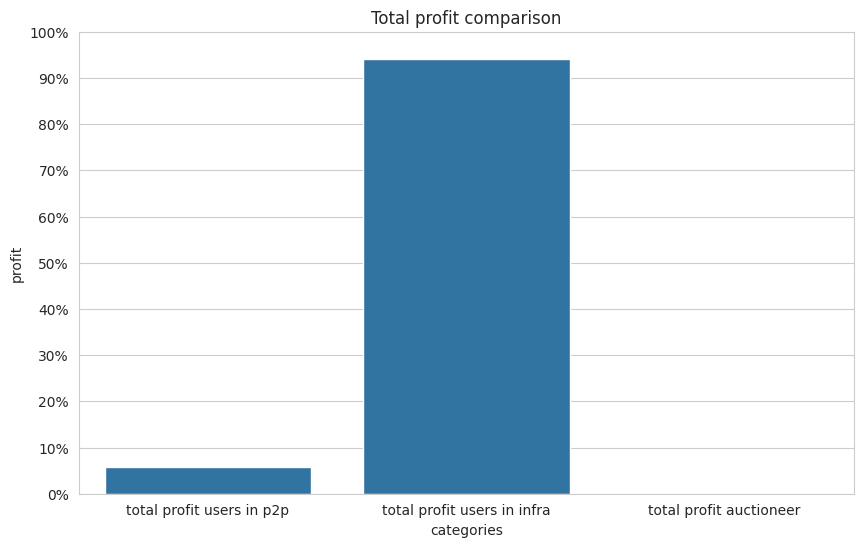

In [ ]:
# infra
from matplotlib.ticker import FuncFormatter
total_profit_users_p2p = np.sum(p2p_tms['players_total_trade_profit'])
total_profit_users_infra = np.sum(infra_tms['players_total_trade_profit'])
total_profit_auctioneer = np.sum(p2p_tms['auctioneer_profit'])
total_profit= total_profit_users_p2p + total_profit_users_infra+ total_profit_auctioneer

profits_map = {
    "categories": ['total profit users in p2p', 'total profit users in infra', 'total profit auctioneer'],
    "values": [total_profit_users_p2p/total_profit*100.0, total_profit_users_infra/total_profit*100.0, total_profit_auctioneer/total_profit*100.0],
}
profits_df = pd.DataFrame(profits_map)
plt.figure(figsize=(10, 6))
plt.title('Total profit comparison')
sns.barplot(x='categories', y='values', data=profits_df)

# Scale the y-axis to show percentages
plt.ylim(0, 100)  # Set the y-axis limits
plt.yticks(ticks=range(0, 101, 10))  # Set y-ticks from 0 to 100 with a step of 10

# Define a function to format the y-axis ticks as percentages
def to_percent(y, position):
    return f'{y}%'

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

# plt.yscale('log')
plt.ylabel('profit')
profits_df


In [ ]:
users = [u for i,u in User._instances.items()]
users_df = pd.json_normalize([u.as_dict() for u in users])
users_columns = ['id', 'score', 'total_trade_p2p', 'total_trade_infra', 'total_trade']
users_df[users_columns]
# users_df

,id,score,total_trade_p2p,total_trade_infra,total_trade
0,151,-4541.002154,1.381352e+07,1.857086e+07,3.238439e+07
1,152,-4607.013505,3.859341e+07,4.970920e+07,8.830261e+07
2,153,-4828.573258,2.279766e+07,1.656426e+07,3.936192e+07
3,154,-4613.947124,3.635735e+07,3.114278e+07,6.750013e+07
4,155,-4602.898668,3.947159e+07,4.189426e+07,8.136584e+07
...,...,...,...,...,...
204,97,-114.539362,4.992525e+06,3.519519e+07,4.018772e+07
205,98,68.256653,4.507206e+06,3.096592e+07,3.547313e+07
206,99,14.381664,5.441572e+06,3.205613e+07,3.749770e+07
207,-1,0.000000,0.000000e+00,6.545135e+09,6.545135e+09


In [ ]:
top_users_largest = {}
top_users_smallest = {}
for feature in users_columns[1:]:
    top_users_largest[feature] = users_df.nlargest(5, feature)  # Get top 5 users for each feature
for feature in users_columns[1:]:
    top_users_smallest[feature] = users_df.nsmallest(5, feature)  # Get bottom 5 users for each feature


# Display the top users for each feature
for feature, users in top_users_largest.items():
    print(f"Top users for {feature}:")
    print(users[['id', feature]])
    print("\n")

# Display the bottom users for each feature
for feature, users in top_users_smallest.items():
    print(f"Bottom users for {feature}:")
    print(users[['id', feature]])
    print("\n")

Top users for score:
     id        score
194  87  1248.920007
123  16  1228.536523
133  26  1180.682262
197  90  1175.433229
144  37  1059.322922


Top users for total_trade_p2p:
     id  total_trade_p2p
12  163     4.901232e+07
47  198     4.374356e+07
99  142     4.131548e+07
4   155     3.947159e+07
28  179     3.921612e+07


Top users for total_trade_infra:
      id  total_trade_infra
207   -1       6.545135e+09
138   31       1.423606e+08
190   83       9.875625e+07
62   105       9.739471e+07
124   17       8.889004e+07


Top users for total_trade:
      id   total_trade
207   -1  6.545135e+09
138   31  1.661708e+08
62   105  1.215694e+08
99   142  1.201555e+08
12   163  1.151583e+08


Bottom users for score:
     id        score
26  177 -4874.685155
8   159 -4855.409279
29  180 -4838.606874
2   153 -4828.573258
45  196 -4825.288120


Bottom users for total_trade_p2p:
      id  total_trade_p2p
207   -1     0.000000e+00
193   86     2.214366e+06
37   188     2.264981e+06
145   38

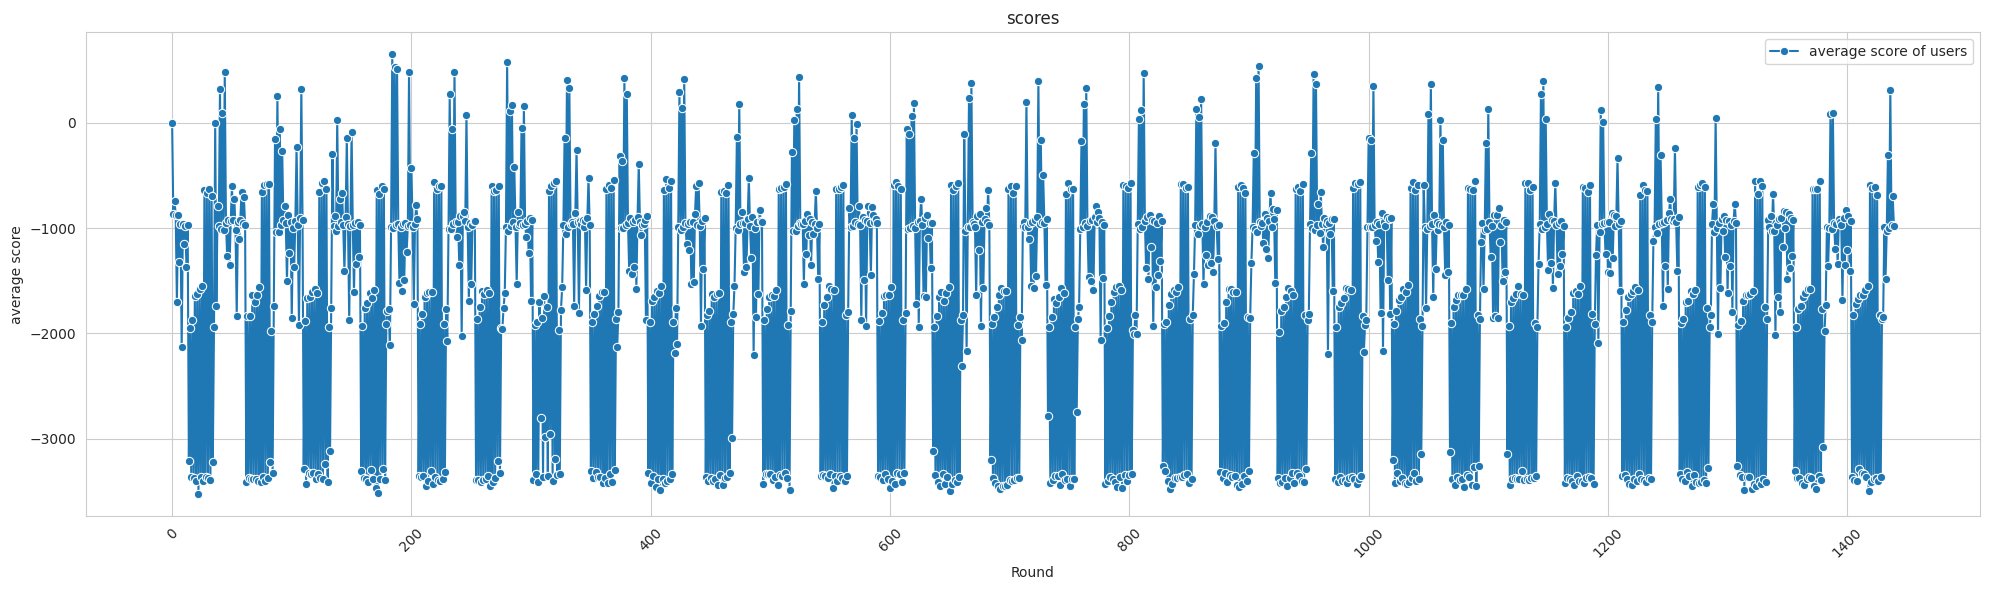

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
sns.lineplot(data=tms, x=tms.index, y='average_score_of_users', marker='o', label='average score of users')
plt.title('scores')
plt.xlabel('Round')
plt.ylabel('average score')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

In [ ]:
# all the transactions
transactions_raw = pd.concat([tm.get_df() for tm in m.tm_list])
transactions_raw

,time,mechanism.buy_price,mechanism.sell_price,mechanism.unit,mechanism.name,buyer.id,buyer.price,buyer.unit,buyer.remaining_unit,seller.id,seller.price,seller.unit,seller.remaining_unit
0,2013-04-05 00:00:00,16.68,16.68,301.000000,Leftover_Clear,67,13.480880,301.0,301.0,-1,16.680000,inf,inf
1,2013-04-05 00:00:00,16.68,16.68,413.000000,Leftover_Clear,115,13.439155,413.0,413.0,-1,16.680000,inf,inf
2,2013-04-05 00:00:00,16.68,16.68,227.000000,Leftover_Clear,151,13.409051,227.0,227.0,-1,16.680000,inf,inf
3,2013-04-05 00:00:00,16.68,16.68,97.000000,Leftover_Clear,172,13.408888,97.0,97.0,-1,16.680000,inf,inf
4,2013-04-05 00:00:00,16.68,16.68,170.000000,Leftover_Clear,187,13.345771,170.0,170.0,-1,16.680000,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2013-05-04 23:00:00,11.30,11.30,36.269431,Leftover_Clear,-1,11.300000,inf,inf,36,14.011316,36.269431,36.269431
162,2013-05-04 23:00:00,11.30,11.30,925.674223,Leftover_Clear,-1,11.300000,inf,inf,15,14.014380,925.674223,925.674223
163,2013-05-04 23:00:00,11.30,11.30,3.870214,Leftover_Clear,-1,11.300000,inf,inf,58,14.109203,3.870214,3.870214
164,2013-05-04 23:00:00,11.30,11.30,98.788474,Leftover_Clear,-1,11.300000,inf,inf,57,14.115681,98.788474,98.788474


In [ ]:
l = []
for i,t in transactions_raw.iterrows():
    b = {
        "time": t['time'],
        "user": t['buyer.id'],
        "is_seller": False,
        "matched_price": t['mechanism.buy_price'],
        "matched_unit": t['mechanism.unit'],
        "bid_price": t['buyer.price'],
        "bid_unit": t['buyer.unit'],
        "remaining_unit": t['buyer.remaining_unit']
    }
    s = {
        "time": t['time'],
        "user": t['seller.id'],
        "is_seller": True,
        "matched_price": t['mechanism.sell_price'],
        "matched_unit": t['mechanism.unit'],
        "bid_price": t['seller.price'],
        "bid_unit": t['seller.unit'],
        "remaining_unit": t['seller.remaining_unit']
    }
    l.append(s)
    l.append(b)
transactions = pd.DataFrame(l)
transactions

,time,user,is_seller,matched_price,matched_unit,bid_price,bid_unit,remaining_unit
0,2013-04-05 00:00:00,-1,True,16.68,301.000000,16.680000,inf,inf
1,2013-04-05 00:00:00,67,False,16.68,301.000000,13.480880,301.000000,301.000000
2,2013-04-05 00:00:00,-1,True,16.68,413.000000,16.680000,inf,inf
3,2013-04-05 00:00:00,115,False,16.68,413.000000,13.439155,413.000000,413.000000
4,2013-04-05 00:00:00,-1,True,16.68,227.000000,16.680000,inf,inf
...,...,...,...,...,...,...,...,...
245815,2013-05-04 23:00:00,-1,False,11.30,3.870214,11.300000,inf,inf
245816,2013-05-04 23:00:00,57,True,11.30,98.788474,14.115681,98.788474,98.788474
245817,2013-05-04 23:00:00,-1,False,11.30,98.788474,11.300000,inf,inf
245818,2013-05-04 23:00:00,98,True,11.30,1228.563002,14.243750,1228.563002,1228.563002


In [ ]:
print("percentage of p2p transactions:")
(1-len(transactions[transactions["matched_price"].isin([p_feat, p_G])])/len(transactions))*100
# transactions

percentage of p2p transactions:


19.27019770563827

In [ ]:
print("percentage of p2p units:")
total_unit_infra=sum(transactions_raw.loc[transactions_raw['mechanism.name'] == 'Leftover_Clear','mechanism.unit'])
total_unit_p2p=sum(transactions_raw.loc[transactions_raw['mechanism.name'] != 'Leftover_Clear','mechanism.unit'])
total_unit_p2p/(total_unit_p2p+total_unit_infra)*100

percentage of p2p units:


6.586660684016206

In [ ]:
ks = [bm.get_breakeven_index() for bm in m.bm_list]

<Axes: title={'center': 'Number of matches in rounds'}, xlabel='breakeven', ylabel='count'>

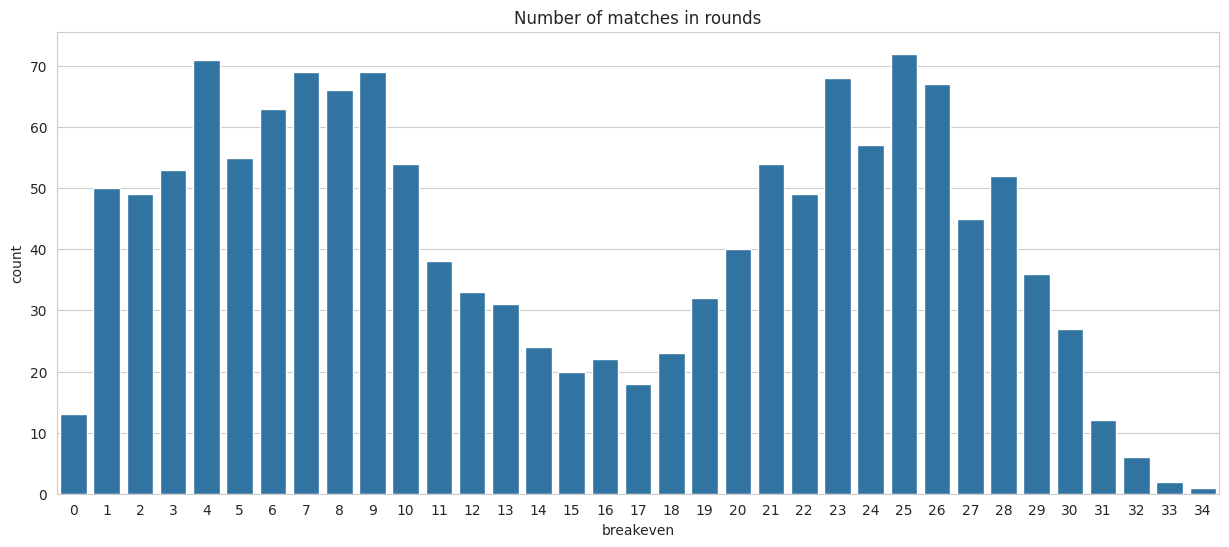

In [ ]:
df_ks = pd.DataFrame(ks, columns=['breakeven'])
plt.figure(figsize=(15, 6))
plt.title('Number of matches in rounds')
sns.countplot(x='breakeven', data=df_ks)
# TODO: how to retrieve rounds that have breakeven == 0? i guess we need a dataframe or something for this

<Axes: title={'center': 'Number of participants in rounds'}, xlabel='participants', ylabel='count'>

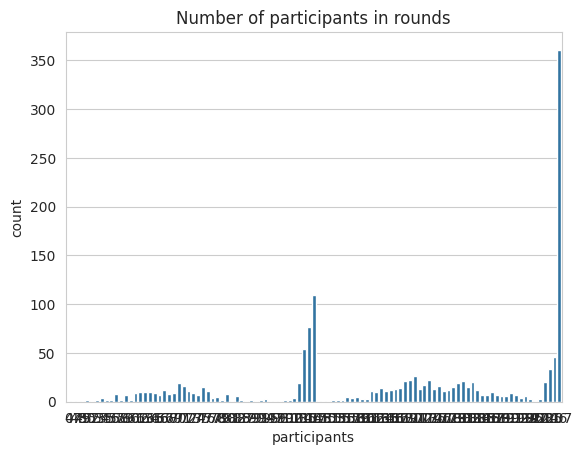

In [ ]:
ps = [bm.get_number_of_participants() for bm in m.bm_list]
df_ps = pd.DataFrame(ps, columns=['participants'])
# plt.figure(figsize=(6, 6))
plt.title('Number of participants in rounds')
sns.countplot(x='participants', data=df_ps)

<Axes: title={'center': 'Number of sellers in rounds'}, xlabel='sellers', ylabel='count'>

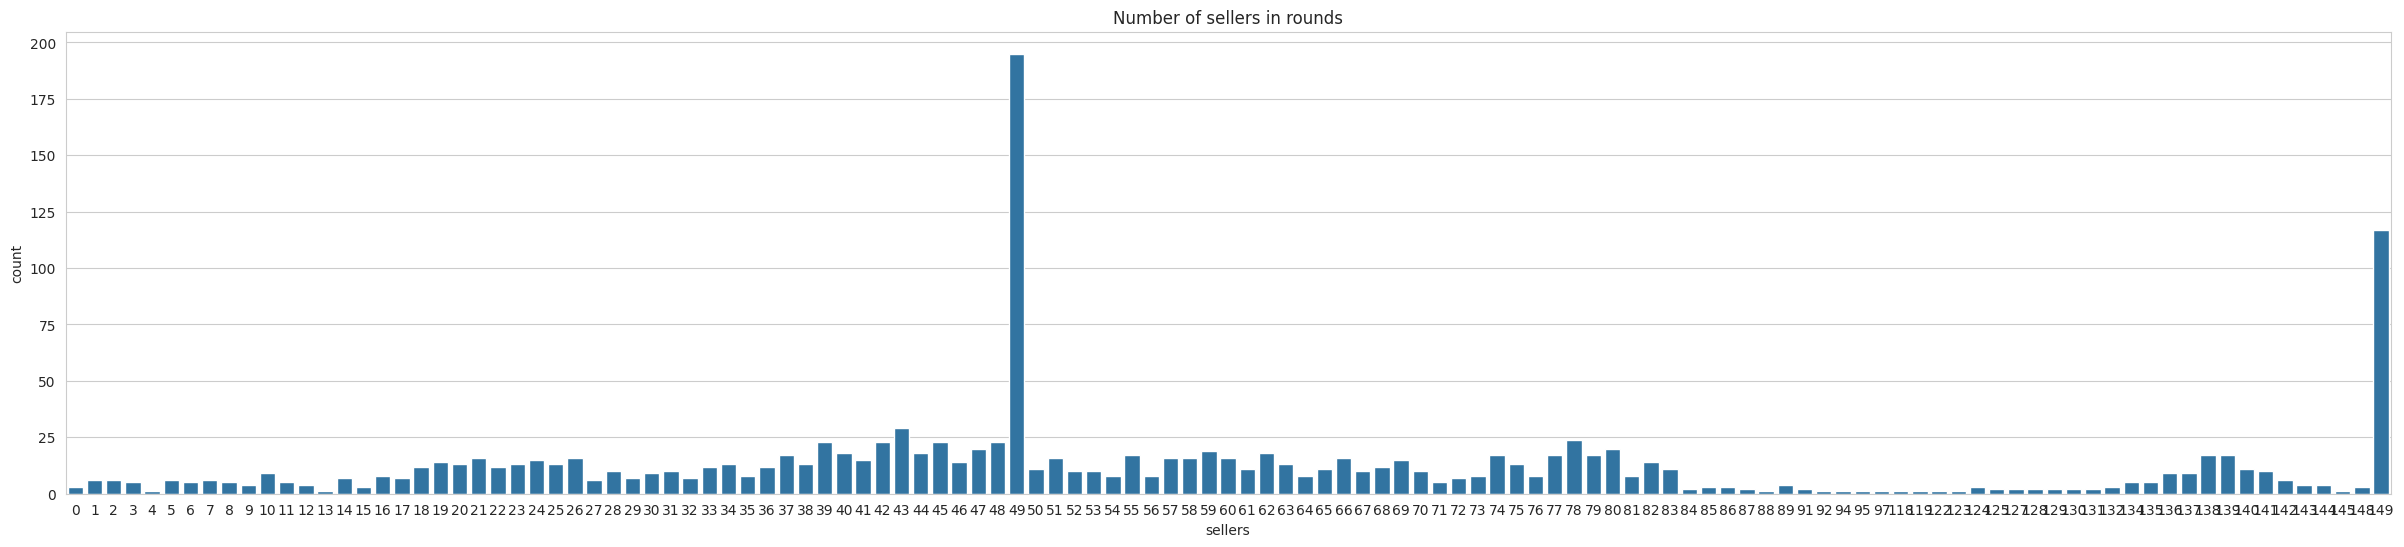

In [ ]:
num_of_sellers_over_time = [len(bm.sellers) for bm in m.bm_list]
df_num_sellers = pd.DataFrame(num_of_sellers_over_time, columns=['sellers'])
plt.figure(figsize=(30, 6))
plt.title('Number of sellers in rounds')
sns.countplot(x='sellers', data=df_num_sellers)

In [ ]:
sum(ps)

222135

In [ ]:
tms.to_csv('mechanisms.csv', index=False)
users_df[users_columns].to_csv('users.csv', index=False)
transactions.to_csv('transactions.csv', index=False)

In [ ]:
print("total profit of users at all")
print(sum(tms['players_total_trade_profit']))
print()

print("total traded unit of users at all")
print(sum(tms['players_total_trade_unit']))
print()

print("total auctioneer profit")
print(sum(tms['auctioneer_profit']))
print()

total profit of users at all
2384079294.303492

total traded unit of users at all
82299068.78890707

total auctioneer profit
1227.3569332173797



,categories,values
0,no generate and no p2p,100.00000
1,generate and no p2p,64.45452
2,generate and p2p,36.99430


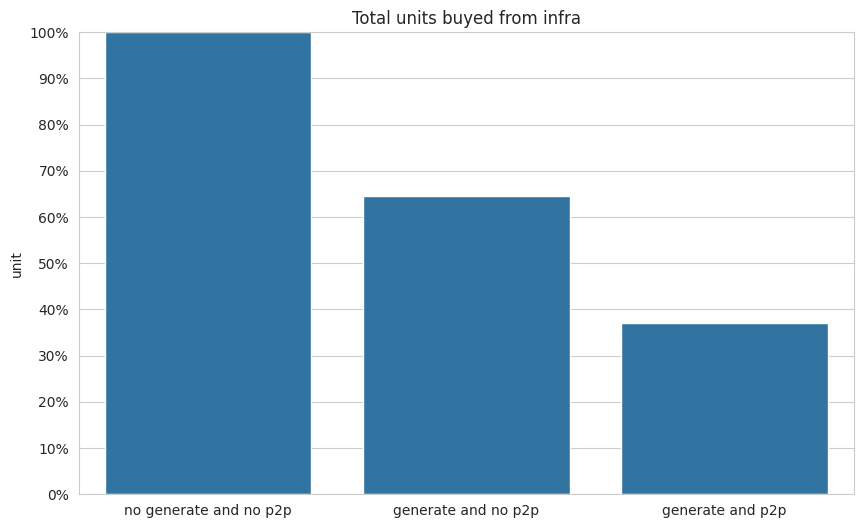

In [ ]:
total_req_scenario1 = np.sum(df['load'])
total_buy_from_infra_scenario1 = total_req_scenario1 * p_G

need = df['load']-df['generate']
need = need[need > 0].reset_index(drop=True)
total_req_scenario2 = np.sum(need)
total_buy_from_infra_scenario2 = total_req_scenario2 * p_G

total_req_scenario3 = np.sum(transactions.loc[(transactions['user'] == -1) & (transactions['is_seller'] == True), 'matched_unit'])
# total_req_scenario3 = 29570692.5
total_buy_from_infra_scenario2 = total_req_scenario3 * p_G

total_req = total_req_scenario1

map = {
    "categories": ['no generate and no p2p', 'generate and no p2p', 'generate and p2p'],
    "values": [total_req_scenario1/total_req*100.0, total_req_scenario2/total_req*120.0, total_req_scenario3/total_req*60.0],
}
l_df = pd.DataFrame(map)
plt.figure(figsize=(10, 6))
plt.title('Total units buyed from infra')
sns.barplot(x='categories', y='values', data=l_df)

# # Scale the y-axis to show percentages
plt.ylim(0, 100)  # Set the y-axis limits
plt.yticks(ticks=range(0, 101, 10))  # Set y-ticks from 0 to 100 with a step of 10

# # Define a function to format the y-axis ticks as percentages
def to_percent(y, position):
    return f'{y}%'

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

# plt.yscale('log')
plt.ylabel('unit')
plt.xlabel('')
l_df